### Set up parallel computing

In [1]:
# import ipyparallel
# from ipyparallel import depend, require

# # create client & view
# rc = ipyparallel.Client()
# dview = rc[:]
# bview = rc.load_balanced_view() # you can set block=True to have this apply globally

# # scatter 'id', so id=0,1,2 on engines 0,1,2
# dview.scatter('node_id', rc.ids, flatten=True)
# print("Engine IDs: ", dview['node_id'])
# # create a Reference to `id`. This will be a different value on each engine
# ref = ipyparallel.Reference('node_id')

In [2]:
from multiprocessing import Pool, cpu_count

import re, os, sys, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame

### Parallel import of libraries

In [3]:
# with dview.sync_imports(): # imports libs across dview
#     import re, os, sys, pickle
#     from pathlib import Path
#     import numpy
#     import pandas
#     from pandas import DataFrame
    
# dview.execute('numpy.random.seed(7)')

# def scatter_func(f):
#     dview.scatter(f.__name__, [f]*len(bview), flatten=True)    

### Analysis dirs

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

### Local code in the scripts dir on the cluster

In [5]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

### Plotting setup

In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

### Silence deprecation warnings (lots from seaborn)

In [7]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

### Load meta data

In [8]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())


## Compile data frame with ARGweaver TMRCA stats

In [9]:
from functools import wraps

def dfstore(groupby=[]):
    def decorator(func):
        @wraps(func)
        def func_wrapper(df):
            df = pandas.read_hdf(str(df))        
            if groupby:
                result_df = df.groupby(groupby).apply(func).reset_index(level=groupby)
#                result_df.index = result_df
            else:
                result_df = func(df)
            return result_df
        return func_wrapper
    return decorator

In [10]:
# DOES THIS MAKE SENSE IF THERE IS ONLY ONE ROW IN EACH GROUP.....


@dfstore(groupby=['MCMC_sample', 'chain'])
#@dfstore()
def tmrca_means(df):    
    return DataFrame({'start': [df.start.min()],
                      'end': [df.end.max()],
                      'tmrca_half': [df.tmrca_half.mean()], 
                      'rel_tmrca_half': [df.tmrca_half.mean() / df.tmrca.mean()], 
                      'tmrca': [df.tmrca.mean()] })

#scatter_func(tmrca_means)

# dir with a hdf with tmrca stats for each window
df_list = list()
for reg in list(regions.keys())  + ['World']:
    tmrca_dir = steps_dir / 'argweaver/tmrca/{}'.format(reg)
    
    with Pool(int(os.environ['SLURM_CPUS_PER_TASK'])) as p:
        df = pandas.concat(p.map(tmrca_means, sorted(tmrca_dir.iterdir())))
#     df = pandas.concat(dview.map(tmrca_means, sorted(tmrca_dir.iterdir())))
    
    df['region'] = reg
    df_list.append(df)
raw_stats = pandas.concat(df_list)
raw_stats.head()

,MCMC_sample,chain,end,rel_tmrca_half,start,tmrca,tmrca_half,region
0,0,1,100000,0.293046,0,47630.174815,13957.808953,Africa
0,0,2,100000,0.260349,0,48605.590963,12654.403238,Africa
0,10,1,100000,0.288177,0,50730.044600,14619.239821,Africa
0,10,2,100000,0.237828,0,50926.465097,12111.714258,Africa
0,20,1,100000,0.254987,0,55762.245537,14218.662969,Africa


## Analyze convergence of mean statistics from samples in the two chains

Plot the tmrca and tmrca_half for each chain:

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


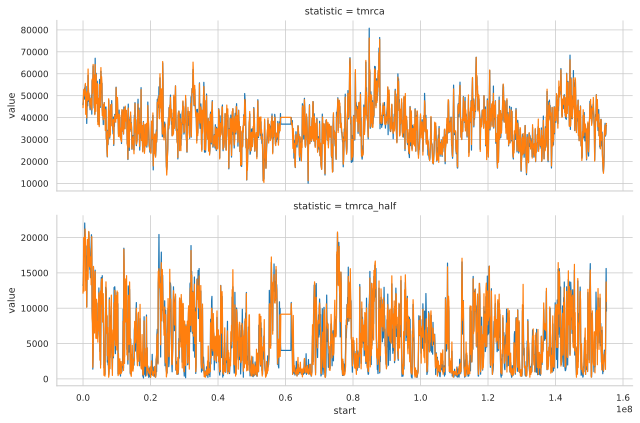

In [11]:
df = (raw_stats
      .loc[lambda df: df.region=='World']
      .groupby(['region', 'start', 'end', 'chain'])
      .mean()
      .reset_index()      
     )
plot_df = pandas.melt(df, 
                  id_vars=['start', 'chain'], 
                  value_vars=['tmrca', 'tmrca_half'], 
                  var_name='statistic', value_name='value')

g = sns.FacetGrid(plot_df, row='statistic', hue='chain', size=3, aspect=3, sharey=False)

fig = g.map(plt.plot, 'start', "value")

# fig = g.map(plt.plot, 'start', "value").fig
# mpld3.display(fig)

See if the correlation between arg stats in the two chains improve the longer they have run:

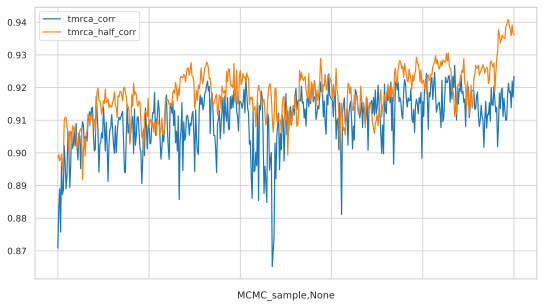

In [12]:
stats_list = ['tmrca', 'tmrca_half']

def cross_chain_corr(df):
    result_df = DataFrame()
    for stat in stats_list:
        chain0 = df.loc[df.chain == 1, ['start', stat]]
        chain1 = df.loc[df.chain == 2, ['start', stat]]
        both = pandas.merge(chain0, chain1, on='start', how='inner', 
                            suffixes=['_chain0', '_chain1'])
        result_df[stat + '_corr'] = [both[stat + '_chain0'].corr(both[stat + '_chain1'])]
    return result_df
        
g = (raw_stats#stats_by_sample_df
     .loc[lambda df: df.region=='World']
     .reset_index()
     .groupby('MCMC_sample')
     .apply(cross_chain_corr)
     .plot(figsize=(9, 5))
    )


## Write mean stats for merged chains to hdf

In [13]:
tmrca_stats = raw_stats.groupby(['region', 'start', 'end']).mean().reset_index()

# write to results
tmrca_stats.to_hdf(str(results_dir / 'tmrca_stats.hdf'), 'df', format='table', mode='w')    

## TMRCA and TMRCA_half across chrX

Plot the stats for both chains pooled:

No handles with labels found to put in legend.


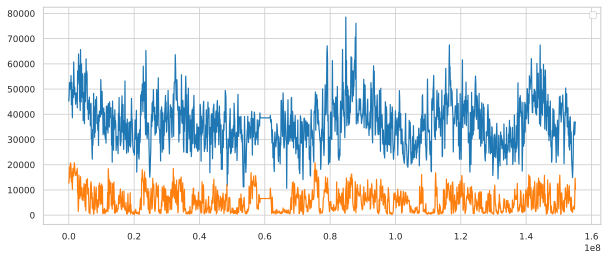

In [14]:
df = tmrca_stats.loc[tmrca_stats.region=='World']
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.start, df.tmrca)
ax.plot(df.start, df.tmrca_half)
ax.legend(loc='upper right')
plt.show()

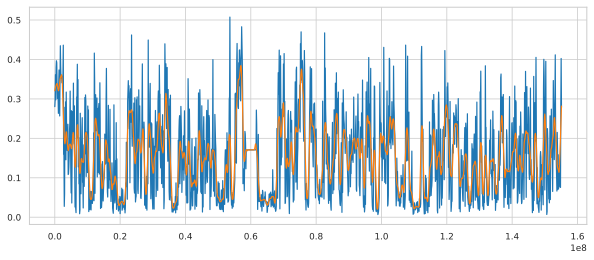

In [15]:
df = tmrca_stats.loc[tmrca_stats.region=='World']
fig, ax = plt.subplots(figsize=(10, 4))
ratio = df.tmrca_half/df.tmrca
ax.plot(df.start, ratio)

filtered = lowess(ratio, df.start, is_sorted=True, frac=0.01, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()

Plot the $-\log\Big[\frac{TMRCA_{half}}{TMRCA}\Big]$

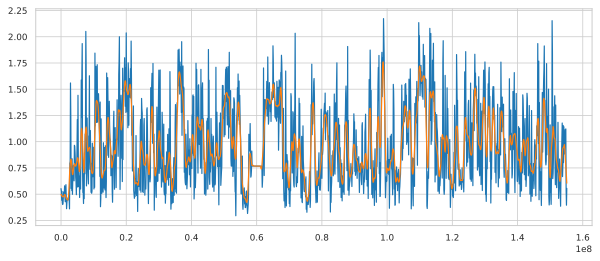

In [16]:
df = tmrca_stats.loc[tmrca_stats.region=='World']
fig, ax = plt.subplots(figsize=(10, 4))
log_ratio = -numpy.log10(df.tmrca_half/df.tmrca)
ax.plot(df.start, log_ratio)

filtered = lowess(log_ratio, df.start, is_sorted=True, frac=0.01, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()

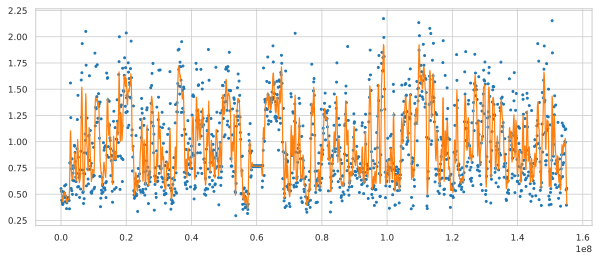

In [17]:
df = tmrca_stats.loc[tmrca_stats.region=='World']
fig, ax = plt.subplots(figsize=(10, 4))
log_ratio = -numpy.log10(df.tmrca_half/df.tmrca)
ax.plot(df.start, log_ratio, 'o', ms=2)

filtered = lowess(log_ratio, df.start, is_sorted=True, frac=0.005, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()